In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
import math

In [115]:
def predictcases(days_to_predict,t_lastknown,t_int,lastnumberofcases,beta0,beta1,K,gamma):

    #create an array for days to be predicted
    predicted_days = range(t_lastknown+1,t_lastknown+1+days_to_predict)

    #initialize predicted cases
    predicted_cases = np.zeros((days_to_predict,))
    
    #initialize daily cases
    predicted_daily_cases = np.zeros((days_to_predict,))

    #intialize beta
    beta = 0

    #fill predicted_cases using discrete time time dependent SIR model
    #Assumption S = N
    for d in predicted_days:

        beta = beta1+(beta0-beta1)*math.exp(-(d-t_int)/K)

        if d == t_lastknown+1:

            predicted_cases[d-t_lastknown-1] = (beta+1)*lastnumberofcases
            predicted_daily_cases[d-t_lastknown-1] = beta*lastnumberofcases

        else:

            predicted_cases[d-t_lastknown-1] = (beta+1)*predicted_cases[d-t_lastknown-2]
            predicted_daily_cases[d-t_lastknown-1] = beta*predicted_cases[d-t_lastknown-2]

    return predicted_daily_cases,predicted_cases,predicted_days

In [116]:
def fitbeta(beta_vector,dates_vector,lockdowndate):

    #intialize the intervention time
    t_int = 0

    #find the intervention time
    for t in range(dates_vector.shape[0]):

        if dates_vector[t] == dates.datestr2num(lockdowndate):

            t_int = t

    #initialize K_errors
    K_errors = np.zeros((200,))
    beta0_records = np.zeros(K_errors.shape)
    beta1_records = np.zeros(K_errors.shape)

    for K in range(1,201):

        #initialize beta0, beta1, error, error_prev
        beta0 = np.mean(beta_vector)
        beta1 = np.mean(beta_vector)
        error = 0
        error_prev = 10000

        #stop the estimation of beta0 and beta1 if the error is not improving
        while(error_prev-error>10**-5 and beta0 > 0 and beta1 > 0):

        #for iters in range(100):


            error_prev = error

            #calculate beta1 based on beta0
            beta1_num = 0
            beta1_den = 0

            for t in range(t_int+1,dates_vector.shape[0]):

                beta1_num += (1-math.exp(-(t-t_int)/K))*beta_vector[t] + beta0*math.exp(-(t-t_int)/K)*(math.exp(-(t-t_int)/K)-1)
                beta1_den += (1-math.exp(-(t-t_int)/K))**2

            beta1 = beta1_num/beta1_den

            #use this beta1 value to estimate beta0

            A = 0
            B = 0
            C = 0

            for t in range(t_int+1):

                A+=beta_vector[t]

            for t in range(t_int+1,dates_vector.shape[0]):

                B+=math.exp(-(t-t_int)/K)*(beta_vector[t]-beta1+beta1*math.exp(-(t-t_int)/K))
                C+=math.exp(-2*(t-t_int)/K)

            beta_0 = (A+B)/(t_int+1+C)

            #beta should be non-negative

            if beta0 < 0:
                beta0 = 0
            if beta1 < 0:
                beta1 = 0


            #calculate the error value

            error = 0

            for t in range(dates_vector.shape[0]):

                if t<t_int+1:

                    error+=(beta_vector[t]-beta0)**2

                else:

                    error+=(beta_vector[t]-beta1-(beta0-beta1)*math.exp(-(t-t_int)/K))**2

        #after the error value is set, record it in order to select the best K later
        K_errors[K-1] = error
        beta0_records[K-1] = beta0
        beta1_records[K-1] = beta1

    #find the K value which gives the minimum array
    index = np.where(K_errors == np.amin(K_errors))
    K = index[0]+1
    beta0 = beta0_records[index]
    beta1 = beta1_records[index]

    return beta0,beta1,K

In [117]:
#import counties data
data = pd.read_csv('us-counties.csv',parse_dates = ['date'])

print(data)

             date      county       state     fips  cases  deaths
0      2020-01-21   Snohomish  Washington  53061.0      1       0
1      2020-01-22   Snohomish  Washington  53061.0      1       0
2      2020-01-23   Snohomish  Washington  53061.0      1       0
3      2020-01-24        Cook    Illinois  17031.0      1       0
4      2020-01-24   Snohomish  Washington  53061.0      1       0
...           ...         ...         ...      ...    ...     ...
173763 2020-05-24    Sublette     Wyoming  56035.0      3       0
173764 2020-05-24  Sweetwater     Wyoming  56037.0     25       0
173765 2020-05-24       Teton     Wyoming  56039.0    100       1
173766 2020-05-24       Uinta     Wyoming  56041.0     12       0
173767 2020-05-24    Washakie     Wyoming  56043.0     20       1

[173768 rows x 6 columns]


In [118]:
#get Cook data
illinois_data = data[data['state'].isin(['Illinois'])]
cook_data = illinois_data[illinois_data['county'].isin(['Cook'])]

#get Cook cases
cook_cases_raw = cook_data['cases']
cook_cases = cook_cases_raw.values

#get Cook dates
cook_dates_raw = cook_data['date']
cook_dates = dates.date2num(cook_dates_raw)

##########################################################################

#get DuPage cases
dupage_data = illinois_data[illinois_data['county'].isin(['DuPage'])]

#get DuPage cases
dupage_cases_raw = dupage_data['cases']
dupage_cases = dupage_cases_raw.values

#get DuPage dates
dupage_dates_raw = dupage_data['date']
dupage_dates = dates.date2num(dupage_dates_raw)

#########################################################################

#get Kane cases
kane_data = illinois_data[illinois_data['county'].isin(['Kane'])]

#get Kane cases
kane_cases_raw = kane_data['cases']
kane_cases = kane_cases_raw.values

#get Kane dates
kane_dates_raw = kane_data['date']
kane_dates = dates.date2num(kane_dates_raw)

#########################################################################

#get Lake cases
lake_data = illinois_data[illinois_data['county'].isin(['Lake'])]

#get Lake cases
lake_cases_raw = lake_data['cases']
lake_cases = lake_cases_raw.values

#get Lake dates
lake_dates_raw = lake_data['date']
lake_dates = dates.date2num(lake_dates_raw)

#########################################################################

#get McHenry cases
mchenry_data = illinois_data[illinois_data['county'].isin(['McHenry'])]

#get McHenry cases
mchenry_cases_raw = mchenry_data['cases']
mchenry_cases = mchenry_cases_raw.values

#get McHenry dates
mchenry_dates_raw = mchenry_data['date']
mchenry_dates = dates.date2num(mchenry_dates_raw)

#########################################################################

#get Will cases
will_data = illinois_data[illinois_data['county'].isin(['Will'])]

#get Will cases
will_cases_raw = will_data['cases']
will_cases = will_cases_raw.values

#get Will dates
will_dates_raw = will_data['date']
will_dates = dates.date2num(will_dates_raw)

#########################################################################

#crop the data before a certain date
cropdate = pd.to_datetime('2020-03-15') #'yyyy-mm-dd'
cook_days = cook_dates[cook_dates_raw>cropdate]
cook_cases = cook_cases[cook_dates_raw>cropdate]

dupage_days = dupage_dates[dupage_dates_raw>cropdate]
dupage_cases = dupage_cases[dupage_dates_raw>cropdate]

kane_days = kane_dates[kane_dates_raw>cropdate]
kane_cases = kane_cases[kane_dates_raw>cropdate]

lake_days = lake_dates[lake_dates_raw>cropdate]
lake_cases = lake_cases[lake_dates_raw>cropdate]

mchenry_days = mchenry_dates[mchenry_dates_raw>cropdate]
mchenry_cases = mchenry_cases[mchenry_dates_raw>cropdate]

will_days = will_dates[will_dates_raw>cropdate]
will_cases = will_cases[will_dates_raw>cropdate]

#set the lockdown date
lockdowndate = '2020-03-20'


In [119]:
#calculate an estimate of gamma using Hubei province data from JHU dataset

#import data
datajhu = pd.read_csv('jhuyagiz.csv',parse_dates = ['date'])

#get Hubei data
hubei_data = datajhu[datajhu['location'].isin(['Hubei'])]

#get Hubei cases
hubei_cases_raw = hubei_data['cases']
hubei_cases = hubei_cases_raw.values

#get Hubei recovered
hubei_recovered_raw = hubei_data['recovered']
hubei_recovered = hubei_recovered_raw.values

#create days array
hubei_days = range(hubei_cases.shape[0])
hubei_beta = np.zeros(hubei_cases.shape[0])
hubei_gamma = np.zeros(hubei_recovered.shape[0])

for d in hubei_days:
    if d < hubei_days[-1]:
        hubei_gamma[d] = (hubei_recovered[d+1]-hubei_recovered[d])/hubei_cases[d]
    else:
        hubei_gamma[d] = hubei_gamma[d-1]

gamma = np.amax(hubei_gamma)
print('gamma = %f' %(gamma))

#########################################################################

gamma = 0.054547


In [120]:
#calculate exact beta for each county

cook_beta_exact = np.zeros(cook_cases.shape)
dupage_beta_exact = np.zeros(dupage_cases.shape)
kane_beta_exact = np.zeros(kane_cases.shape)
lake_beta_exact = np.zeros(lake_cases.shape)
mchenry_beta_exact = np.zeros(mchenry_cases.shape)
will_beta_exact = np.zeros(will_cases.shape)


for d in range(cook_cases.shape[0]):

    if d < cook_cases.shape[0]-1:
        cook_beta_exact[d] = (cook_cases[d+1]-cook_cases[d])/cook_cases[d]
    else:
        cook_beta_exact[d] = cook_beta_exact[d-1]

for d in range(dupage_cases.shape[0]):

    if d < dupage_cases.shape[0]-1:
        dupage_beta_exact[d] = (dupage_cases[d+1]-dupage_cases[d])/dupage_cases[d]
    else:
        dupage_beta_exact[d] = dupage_beta_exact[d-1]

for d in range(kane_cases.shape[0]):

    if d < kane_cases.shape[0]-1:
        kane_beta_exact[d] = (kane_cases[d+1]-kane_cases[d])/kane_cases[d]
    else:
        kane_beta_exact[d] = kane_beta_exact[d-1]

for d in range(lake_cases.shape[0]):

    if d < lake_cases.shape[0]-1:
        lake_beta_exact[d] = (lake_cases[d+1]-lake_cases[d])/lake_cases[d]
    else:
        lake_beta_exact[d] = lake_beta_exact[d-1]

for d in range(mchenry_cases.shape[0]):

    if d < mchenry_cases.shape[0]-1:
        mchenry_beta_exact[d] = (mchenry_cases[d+1]-mchenry_cases[d])/mchenry_cases[d]
    else:
        mchenry_beta_exact[d] = mchenry_beta_exact[d-1]

for d in range(will_cases.shape[0]):

    if d < will_cases.shape[0]-1:
        will_beta_exact[d] = (will_cases[d+1]-will_cases[d])/will_cases[d]
    else:
        will_beta_exact[d] = will_beta_exact[d-1]


In [121]:
#fit the model parameters for each county
cook_beta0,cook_beta1,cook_K = fitbeta(cook_beta_exact,cook_days,lockdowndate)
dupage_beta0,dupage_beta1,dupage_K = fitbeta(dupage_beta_exact,dupage_days,lockdowndate)
kane_beta0,kane_beta1,kane_K = fitbeta(kane_beta_exact,kane_days,lockdowndate)
lake_beta0,lake_beta1,lake_K = fitbeta(lake_beta_exact,lake_days,lockdowndate)
mchenry_beta0,mchenry_beta1,mchenry_K = fitbeta(mchenry_beta_exact,mchenry_days,lockdowndate)
will_beta0,will_beta1,will_K = fitbeta(will_beta_exact,will_days,lockdowndate)

#print the fitted values for each county
print('cook: %f, %f, %d' %(cook_beta0,cook_beta1,cook_K))
print('dupage: %f, %f, %d' %(dupage_beta0,dupage_beta1,dupage_K))
print('kane: %f, %f, %d' %(kane_beta0,kane_beta1,kane_K))
print('lake: %f, %f, %d' %(lake_beta0,lake_beta1,lake_K))
print('mchenry: %f, %f, %d' %(mchenry_beta0,mchenry_beta1,mchenry_K))
print('will: %f, %f, %d' %(will_beta0,will_beta1,will_K))

cook: 0.110451, 0.000000, 53
dupage: 0.147984, 0.000000, 38
kane: 0.122394, 0.000000, 80
lake: 0.122275, 0.000000, 48
mchenry: 0.107842, 0.000000, 63
will: 0.170612, 0.000000, 38


In [122]:
days = cook_days

#find the intervention time
for t in range(days.shape[0]):

    if days[t] == dates.datestr2num(lockdowndate):

        t_int = t

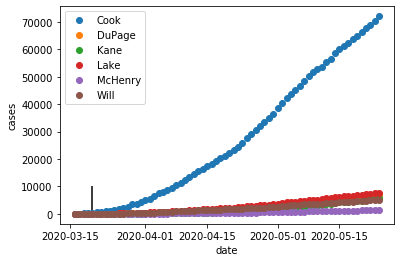

In [123]:
#plot cases in each county
plt.figure(1)
plot1, = plt.plot_date(days,cook_cases,xdate = True)
plot2, = plt.plot_date(days,dupage_cases,xdate = True)
plot3, = plt.plot_date(days,kane_cases,xdate = True)
plot4, = plt.plot_date(days,lake_cases,xdate = True)
plot5, = plt.plot_date(days,mchenry_cases,xdate = True)
plot6, = plt.plot_date(days,will_cases,xdate = True)
plt.vlines(x = dates.datestr2num(lockdowndate),ymin = 0,ymax = 10000)
plt.legend([plot1,plot2,plot3,plot4,plot5,plot6],['Cook','DuPage','Kane','Lake','McHenry','Will'])
plt.xlabel('date')
plt.ylabel('cases')
plt.show()

In [124]:
days_num = range(days.shape[0])
t_smooth = np.linspace(0,days.shape[0],num = 1000)
cook_beta_smooth = np.zeros(t_smooth.shape)
dupage_beta_smooth = np.zeros(t_smooth.shape)
kane_beta_smooth = np.zeros(t_smooth.shape)
lake_beta_smooth = np.zeros(t_smooth.shape)
mchenry_beta_smooth = np.zeros(t_smooth.shape)
will_beta_smooth = np.zeros(t_smooth.shape)
for i in range(t_smooth.shape[0]):
    if t_smooth[i] <= t_int:
        cook_beta_smooth[i] = cook_beta0
    else:
        cook_beta_smooth[i] = cook_beta1+(cook_beta0-cook_beta1)*math.exp(-(t_smooth[i]-t_int)/cook_K)
for i in range(t_smooth.shape[0]):
    if t_smooth[i] <= t_int:
        dupage_beta_smooth[i] = dupage_beta0
    else:
        dupage_beta_smooth[i] = dupage_beta1+(dupage_beta0-dupage_beta1)*math.exp(-(t_smooth[i]-t_int)/dupage_K)
for i in range(t_smooth.shape[0]):
    if t_smooth[i] <= t_int:
        kane_beta_smooth[i] = kane_beta0
    else:
        kane_beta_smooth[i] = kane_beta1+(kane_beta0-kane_beta1)*math.exp(-(t_smooth[i]-t_int)/kane_K)
for i in range(t_smooth.shape[0]):
    if t_smooth[i] <= t_int:
        lake_beta_smooth[i] = lake_beta0
    else:
        lake_beta_smooth[i] = lake_beta1+(lake_beta0-lake_beta1)*math.exp(-(t_smooth[i]-t_int)/lake_K)
for i in range(t_smooth.shape[0]):
    if t_smooth[i] <= t_int:
        mchenry_beta_smooth[i] = mchenry_beta0
    else:
        mchenry_beta_smooth[i] = mchenry_beta1+(mchenry_beta0-mchenry_beta1)*math.exp(-(t_smooth[i]-t_int)/mchenry_K)
for i in range(t_smooth.shape[0]):
    if t_smooth[i] <= t_int:
        will_beta_smooth[i] = will_beta0
    else:
        will_beta_smooth[i] = will_beta1+(will_beta0-will_beta1)*math.exp(-(t_smooth[i]-t_int)/will_K)

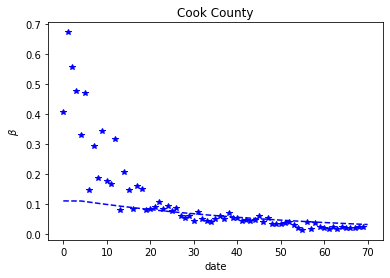

In [125]:
plt.figure(2)
plt.plot(days_num,cook_beta_exact,'b*')
plt.plot(t_smooth,cook_beta_smooth,'--b')
plt.title('Cook County')
plt.xlabel('date')
plt.ylabel('$\\beta$')
plt.show()

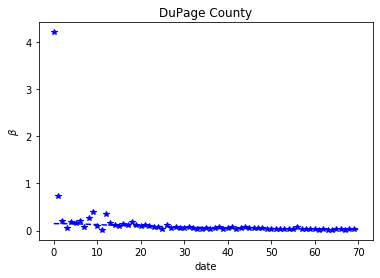

In [126]:
plt.figure(3)
plt.plot(days_num,dupage_beta_exact,'b*')
plt.plot(t_smooth,dupage_beta_smooth,'--b')
plt.title('DuPage County')
plt.xlabel('date')
plt.ylabel('$\\beta$')
plt.show()

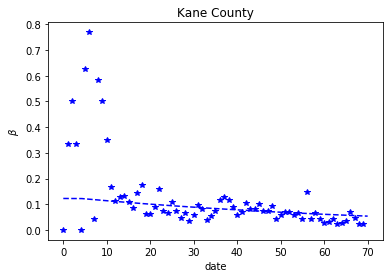

In [127]:
plt.figure(4)
plt.plot(days_num,kane_beta_exact,'b*')
plt.plot(t_smooth,kane_beta_smooth,'--b')
plt.title('Kane County')
plt.xlabel('date')
plt.ylabel('$\\beta$')
plt.show()

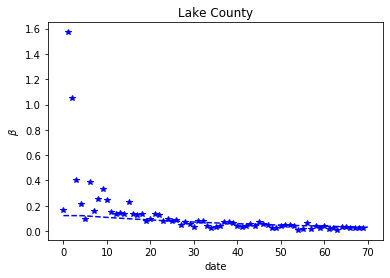

In [128]:
plt.figure(5)
plt.plot(days_num,lake_beta_exact,'b*')
plt.plot(t_smooth,lake_beta_smooth,'--b')
plt.title('Lake County')
plt.xlabel('date')
plt.ylabel('$\\beta$')
plt.show()

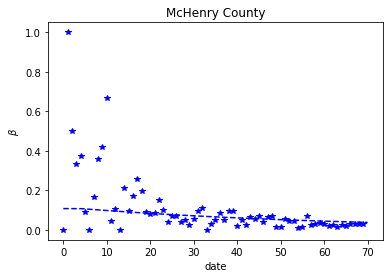

In [129]:
plt.figure(6)
plt.plot(days_num,mchenry_beta_exact,'b*')
plt.plot(t_smooth,mchenry_beta_smooth,'--b')
plt.title('McHenry County')
plt.xlabel('date')
plt.ylabel('$\\beta$')
plt.show()

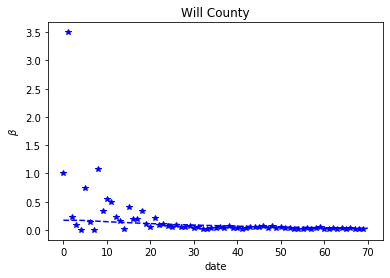

In [130]:
plt.figure(7)
plt.plot(days_num,will_beta_exact,'b*')
plt.plot(t_smooth,will_beta_smooth,'--b')
plt.title('Will County')
plt.xlabel('date')
plt.ylabel('$\\beta$')
plt.show()

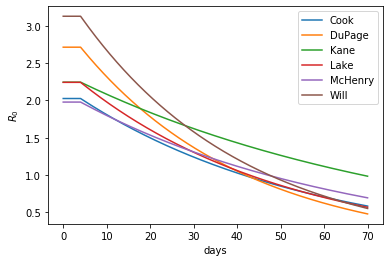

In [131]:
plt.figure(8)
plt.plot(t_smooth,np.divide(cook_beta_smooth,gamma),label = 'Cook')
plt.plot(t_smooth,np.divide(dupage_beta_smooth,gamma),label = 'DuPage')
plt.plot(t_smooth,np.divide(kane_beta_smooth,gamma),label = 'Kane')
plt.plot(t_smooth,np.divide(lake_beta_smooth,gamma),label = 'Lake')
plt.plot(t_smooth,np.divide(mchenry_beta_smooth,gamma),label = 'McHenry')
plt.plot(t_smooth,np.divide(will_beta_smooth,gamma),label = 'Will')
plt.legend()
plt.xlabel('days')
plt.ylabel('$R_0$')
plt.show()

In [132]:
days_to_predict = 100 #the number of days to be predicted

cook_daily_predicted,cook_cases_predicted, cook_predicted_days = predictcases(days_to_predict,days_num[-1], \
t_int,cook_cases[-1],cook_beta0,cook_beta1,cook_K,gamma)
dupage_daily_predicted,dupage_cases_predicted, dupage_predicted_days = predictcases(days_to_predict,days_num[-1], \
t_int,dupage_cases[-1],dupage_beta0,dupage_beta1,dupage_K,gamma)
kane_daily_predicted,kane_cases_predicted, kane_predicted_days = predictcases(days_to_predict,days_num[-1], \
t_int,kane_cases[-1],kane_beta0,kane_beta1,kane_K,gamma)
lake_daily_predicted,lake_cases_predicted, lake_predicted_days = predictcases(days_to_predict,days_num[-1], \
t_int,lake_cases[-1],lake_beta0,lake_beta1,lake_K,gamma)
mchenry_daily_predicted,mchenry_cases_predicted, mchenry_predicted_days = predictcases(days_to_predict,days_num[-1], \
t_int,mchenry_cases[-1],mchenry_beta0,mchenry_beta1,mchenry_K,gamma)
will_daily_predicted,will_cases_predicted, will_predicted_days = predictcases(days_to_predict,days_num[-1], \
t_int,will_cases[-1],will_beta0,will_beta1,will_K,gamma)

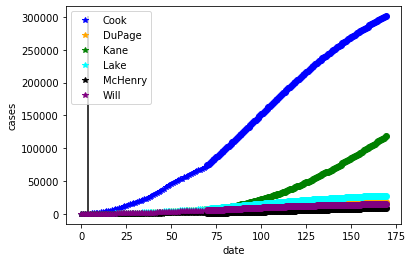

In [133]:
#plot predicted cases for each county

plt.figure(9)
plt.plot(days_num,cook_cases,'*',color='blue',label = 'Cook')
plt.plot(days_num,dupage_cases,'*',color='orange',label = 'DuPage')
plt.plot(days_num,kane_cases,'*',color='green',label = 'Kane')
plt.plot(days_num,lake_cases,'*',color='cyan',label = 'Lake')
plt.plot(days_num,mchenry_cases,'*',color = 'black',label = 'McHenry')
plt.plot(days_num,will_cases,'*',color = 'purple',label = 'Will')

plt.plot(cook_predicted_days,cook_cases_predicted,'o',color = 'blue')
plt.plot(dupage_predicted_days,dupage_cases_predicted,'o',color='orange')
plt.plot(kane_predicted_days,kane_cases_predicted,'o',color='green')
plt.plot(lake_predicted_days,lake_cases_predicted,'o',color='cyan')
plt.plot(mchenry_predicted_days,mchenry_cases_predicted,'o',color = 'black')
plt.plot(will_predicted_days,will_cases_predicted,'o',color = 'purple')

plt.vlines(x = t_int,ymin = 0,ymax = np.amax(cook_cases_predicted))
plt.legend()
plt.xlabel('date')
plt.ylabel('cases')
plt.show()

In [134]:
#estimate recovered for each Cook County

cook_recovered = np.zeros((days_num[-1]+days_to_predict+1,))

for d in range(1,days_num[-1]+days_to_predict+1):

    if d < days_num[-1]+2:

        cook_recovered[d] = gamma*cook_cases[d-1]+cook_recovered[d-1]

    else:

        cook_recovered[d] = gamma*cook_cases_predicted[d-days_num[-1]-1]+cook_recovered[d-1]

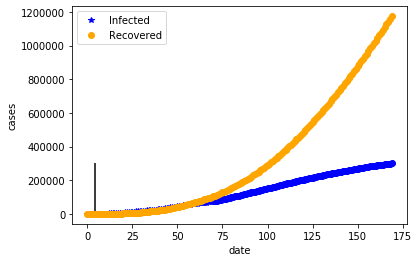

In [135]:
days_all = range(days_num[-1]+days_to_predict+1)

plt.figure(10)

plt.plot(days_num,cook_cases,'*',color='blue',label = 'Infected')
plt.plot(cook_predicted_days,cook_cases_predicted,'o',color = 'blue')
plt.plot(days_all,cook_recovered,'o',color = 'orange',label = 'Recovered')

plt.vlines(x = t_int,ymin = 0,ymax = np.amax(cook_cases_predicted))
plt.legend()
plt.xlabel('date')
plt.ylabel('cases')
plt.show()


In [136]:
#get newly confirmed cases for each day at each county

cook_daily = np.diff(cook_cases)
dupage_daily = np.diff(dupage_cases)
kane_daily = np.diff(kane_cases)
lake_daily = np.diff(lake_cases)
mchenry_daily = np.diff(mchenry_cases)
will_daily = np.diff(will_cases)

In [137]:
#create an array of dates

base_date = pd.to_datetime('2020-03-16') #one day after the cropdate
date_list = [base_date + datetime.timedelta(days=x) for x in range(cook_daily.shape[0])]
date_list_predicted = [date_list[-1] + datetime.timedelta(days=x+1) for x in range(cook_daily_predicted.shape[0])]

date_list = dates.date2num(date_list)
date_list_predicted = dates.date2num(date_list_predicted)


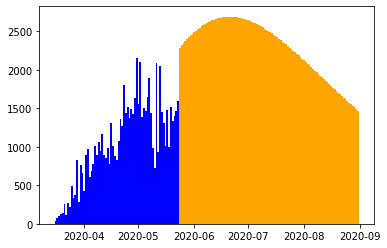

In [138]:
#plot new cases each day
plt.figure(11)

ax = plt.subplot(111)
ax.bar(date_list,cook_daily,width=1,color = 'blue')
ax.bar(date_list_predicted,cook_daily_predicted,width=1,color = 'orange')
ax.xaxis_date()
plt.show()
